# Date Translation

In this project, we build a LSTM-based seq2seq model with attention mechanism to translate human-readable date to machine-readable date. Seq2seq is a general category of machine learning models that take a sequence as input and output another sequence. A seq2seq model is composed of an encoder to encode the input sequence and a decoder to generate the output sequence based on the encoded information from the input sequence. The performance of a vanilla LSTM(/GRU/RNN)-based seq2seq model is limited by the amount of information that can be carried from the encoder to the decoder through the encoder final hidden state. To overcome this bottleneck, attention mechanism is invented by researchers, which allows the decoder to utilize the information of all the hidden states of the encoder at every step of generating a new element during the decoding stage. In that way, the model learns to pay attention to different parts of the input sequence when generating different parts of the output sequence, which results in better performance. This concept of attention was further improved later giving rise to the next generation NLP models, i.e. transformer, BERT and GPT, which are based upon multi-head self-attention. Seq2seq models can handle many NLP tasks such as language translation, conversational chatbot, text summarization and question answering, etc. Here, we build a date translator to automate the process of translating human-readable date to machine-readable date.

## Data preparation & preprocessing

### Import libraries

In [182]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from faker import Faker
from babel.dates import format_date
from preprocessing import *

### Prepare the dataset

The dataset needs to be formatted as
```
train_raw = [
             ["6/1/05", "2005-06-01"],
             ["Sep 6, 2019", "2019-09-06"],
             ["December 9, 1974", "1974-12-09"],
             ["28 December, 1979", "1979-12-28"],
             ["14 Dec 2001", "2001-12-14"]
            ]
```

In [183]:
fake = Faker()

Faker.seed(101)
random.seed(101)

In [184]:
FORMATS = ['medium', # MMM d, YYY
           'long', # MMMM dd, YYY
           'd MMM, YYY', 
           'dd MMMM, YYY',
           'YYY, MMM d',
           'YYY, MMMM dd',
           'YYY, d MMM', 
           'YYY, dd MMMM',
           'dd/MM/YYY',
           'd/MM/YYY',
           'YYYY/MM/dd',
           'YYYY/MM/d']

In [185]:
for form in FORMATS:
    date = fake.date_object()
    print(f"{format_date(date, format=form, locale='en')} -> {date}")

Jul 19, 2009 -> 2009-07-19
April 3, 1983 -> 1983-04-03
11 Sep, 2006 -> 2006-09-11
29 May, 1994 -> 1994-05-29
2001, Oct 15 -> 2001-10-15
1973, April 20 -> 1973-04-20
2015, 24 Feb -> 2015-02-24
2004, 07 April -> 2004-04-07
06/08/1984 -> 1984-08-06
20/12/2010 -> 2010-12-20
1985/02/01 -> 1985-02-01
1989/08/20 -> 1989-08-20


In [186]:
def random_date():
    dt = fake.date_object()

    try:
        date = format_date(dt, format = random.choice(FORMATS), locale = 'en')
        human_readable = ' '.join(date.lower().split())
        machine_readable = dt.isoformat()

    except:
        print()
        raise RuntimeError

    return [human_readable, machine_readable]

In [187]:
def create_dataset(num): 
    return [random_date() for i in range(num)]

In [188]:
tot_num_data = 40000
num_train = int(tot_num_data * 0.7)
num_val = int(tot_num_data * 0.1)
num_test = int(tot_num_data * 0.2)

original_train = create_dataset(num_train)
original_val = create_dataset(num_val)
original_test = create_dataset(num_test)
preprocessor = DTPreprocessor()
cleaned_train = preprocessor.cleanse_corpus(original_train)
cleaned_val = preprocessor.cleanse_corpus(original_val)
cleaned_test = preprocessor.cleanse_corpus(original_test)


Take a look at the cleaned data

In [189]:
cleaned_train.head(10)

,0,1
0,14/01/2003,2003-01-14
1,"13 february, 2017",2017-02-13
2,14/06/1984,1984-06-14
3,"1992, may 23",1992-05-23
4,"1999, 22 october",1999-10-22
5,"oct 15, 1974",1974-10-15
6,1987/05/16,1987-05-16
7,26/02/1983,1983-02-26
8,"17 december, 1980",1980-12-17
9,18/01/1976,1976-01-18


### Tokenization, building vocabulary and preparing the sequences to train the seq2seq model

Fit the preprocessor on the cleansed corpus.

In [190]:
preprocessor.fit_on_corpus(cleaned_train)

Inspect the outputs.

In [191]:
print(f"The sorted vocab for human:\n{preprocessor.human_sorted_vocab}")
print("*"*100)
print(f"The sorted vocab for machine:\n{preprocessor.machine_sorted_vocab}")
print("#"*100)
print("The word-to-index map for human:")
for word, idx in list(preprocessor.human_char2idx.items()):
    print(f"{word}: {idx}")
print("*"*100)
print("The word-to-index map for machine:")
for word, idx in list(preprocessor.machine_char2idx.items()):
    print(f"{word}: {idx}")


The sorted vocab for human:
[('1', 40749), ('0', 34503), ('2', 30359), ('9', 27236), ('7', 11583), ('8', 11421), ('e', 10886), ('a', 9342), ('r', 8496), ('3', 7529), ('u', 6865), ('5', 6347), ('6', 6189), ('4', 6031), ('m', 5534), ('j', 4625), ('n', 4622), ('b', 4533), ('c', 3969), ('o', 3925), ('y', 3919), ('p', 3166), ('t', 3148), ('s', 2363), ('l', 2321), ('d', 1567), ('v', 1539), ('g', 1537), ('f', 1402), ('h', 792), ('i', 779)]
****************************************************************************************************
The sorted vocab for machine:
[('0', 54826), ('1', 48560), ('2', 33341), ('9', 28838), ('7', 13134), ('8', 12955), ('3', 9100), ('5', 7950), ('6', 7707), ('4', 7589)]
####################################################################################################
The word-to-index map for human:
PAD: 0
SOS: 1
EOS: 2
UNK: 3
1: 4
0: 5
2: 6
9: 7
7: 8
8: 9
e: 10
a: 11
r: 12
3: 13
u: 14
5: 15
6: 16
4: 17
m: 18
j: 19
n: 20
b: 21
c: 22
o: 23
y: 24
p: 25
t: 26
s

In [192]:
SOS_token_idx = preprocessor.machine_char2idx['SOS']
print(SOS_token_idx)

1


## Build the model

### Import libraries

In [194]:
import math, copy
import torch
import torch.nn as nn

The encoder, which is made up of ```num_layers``` layers of bidirectional LSTM cells.

In [195]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers = 1, dropout = 0.1):
        super().__init__()
        
        # emb_dim is the input_dim of the LSTM
        input_dim = emb_dim

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedder = nn.Embedding(vocab_size, emb_dim)

        self.dropout = nn.Dropout(dropout)   
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout = dropout, bidirectional = True, batch_first = True)   

        # We need one fully connected layer to map the 
        # 2*hidden_dim-dimensional bidirectional output to hidden_dim dimensions
        self.fc_hidden = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc_cell = nn.Linear(2 * hidden_dim, hidden_dim)

    def forward(self, seqs):
        # seqs shape: (batch_size, seq_length)
        embedded = self.embedder(seqs) 
        # embedded shape: (batch_size, seq_length, input_dim) 
        
        outputs, (hidden, cell) = self.lstm(embedded)
        # bidirectional = True, so
        # outputs shape: (batch_size, seq_length, 2 * hidden_dim)
        # hidden shape: (2 * num_layers, batch_size, hidden_dim)
        # cell shape: (2 * num_layers, batch_size, hidden_dim)

        # Firstly, only take the fisrt layer. After concatenating the forward and backward final states:
        # hidden shape: (1, batch_size, 2 * hidden_dim)
        # cell shape: (1, batch_size, 2 * hidden_dim)
        output_hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim = 2))
        output_cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim = 2))
        # After the fc later:
        # output_hidden shape: (1, batch_size, hidden_dim)
        # output_cell shape: (1, batch_size, hidden_dim)
        
        # Then, take all the following layers if there is any
        if self.num_layers > 1:
            for idx in range(1, self.num_layers):
                output_hidden = torch.cat((self.fc_hidden(torch.cat((hidden[2*idx:2*idx+1], hidden[2*idx+1:2*idx+2]), dim = 2)), output_hidden), dim = 0)
                output_cell = torch.cat((self.fc_cell(torch.cat((cell[2*idx:2*idx+1], cell[2*idx+1:2*idx+2]), dim = 2)), output_cell), dim = 0)
        # output_hidden shape: (num_layers, batch_size, hidden_dim)
        # output_cell shape: (num_layers, batch_size, hidden_dim)

        return outputs, output_hidden, output_cell

The decoder, which is made up of ```num_layers``` (the same number of layers as encoder) unidirectional LSTM cells.

In [196]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, output_dim, num_layers = 1, dropout = 0.1):
        super().__init__()

        # emb_dim is the input_dim of the LSTM
        input_dim = emb_dim
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        self.embedder = nn.Embedding(vocab_size, emb_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_dim + 2 * hidden_dim, hidden_dim, num_layers, dropout = dropout, batch_first = True)
        self.attention_layer = AttentionLayer(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, seqs, encoder_outputs, hidden, cell):
        # seqs shape: (batch_size, 1)
        embedded = self.embedder(seqs)
        # embedded shape: (batch_size, 1, input_dim)
        # encoder_outputs shape: (batch_size, en_seq_len, 2 * hidden_dim)
        # hidden (cell) shape: (num_layers, batch_size, hidden_dim)

        # Only take the states from the last layer of the last time step 
        last_hidden = hidden[-1:, :, :]
        # last_hidden shape: (1, batch_size, hidden_dim)
        
        context_vector, _ = self.attention_layer(encoder_outputs, last_hidden)
        # context_vector shape: (batch_size, 1, 2 * hidden_dim)

        embedded = torch.cat((embedded, context_vector), dim = 2)
        # embedded shape: (batch_size, 1, input_dim + 2 * hidden_dim)

        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # outputs shape: (batch_size, 1, hidden_dim)
        # hidden shape: (num_layers, batch_size, hidden_dim)
        # cell shape: (num_layers, batch_size, hidden_dim)

        predictions = self.fc(outputs)
        # predictions shape: (batch_size, 1, output_dim)

        return predictions, hidden, cell

The attention layer that computes the context vector at each recurrent step of the decoder.

In [197]:
class AttentionLayer(nn.Module):
    """
            energies: e = relu(V * concat(values, query))
            attentions: alpha = softmax(e)
            context_vector: a = sum(alpha * values)
    """
    def __init__(self, hidden_dim):
        super().__init__()

        self.hidden_dim = hidden_dim
        # Build a fc layer to take the (i-1)th hidden state of decoder and jth hidden state from encoder
        # and map them to a energy value
        self.energy = nn.Linear(3 * hidden_dim, 1)
        # Use a softmax layer to normalize the energies into probabilities
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)  

    def forward(self, values, query):
        """
                values (encoder_outputs): (batch_size, seq_length, 2 * hidden_dim)
                query (de_last_step_hidden): (1, batch_size, hidden_dim) -> (batch_size, en_seq_len, hidden_dim)
                energies: (batch_size, en_seq_len, 1)
                attentions: (batch_size, en_seq_len, 1)
                context_vector: (batch_size, 1, 2 * hidden_dim)
        """
        en_seq_len = values.shape[1]
        query_expanded = query.repeat(en_seq_len, 1, 1)
        # query_expanded shape: (en_seq_len, batch_size, hidden_dim)
        query_reshaped = query_expanded.transpose(0, 1)
        # query_reshaped shape: (batch_size, en_seq_len, hidden_dim)

        energies = self.relu(self.energy(torch.cat((query_reshaped, values), dim = 2)))
        # energies shape: (batch_size, en_seq_len, 1)
        attentions = self.softmax(energies)
        # attentions shape: (batch_size, en_seq_len, 1)

        context_vector = torch.bmm(attentions.permute(0, 2, 1), values)
        # context_vector shape: (batch_size, 1, 2 * hidden_dim)

        return context_vector, attentions

The seq2seq model.

In [198]:
class Seq2seq(nn.Module):
    def __init__(self, 
                 en_vocab_size,
                 de_vocab_size,
                 en_emb_dim,
                 de_emb_dim,
                 hidden_dim,
                 num_layers = 1,
                 dropout = 0.1,
                 device = 'cpu'):
        super().__init__()
        self.device = device
        self.de_vocab_size = de_vocab_size
        self.encoder = Encoder(en_vocab_size, en_emb_dim, hidden_dim, num_layers = num_layers, dropout = dropout)
        self.decoder = Decoder(de_vocab_size, de_emb_dim, hidden_dim, de_vocab_size, num_layers = num_layers, dropout = dropout)

    def update_device(self, device):
        self.device = device
        
    def infer(self, source_seqs, max_target_seq_len, SOS_token_idx):
        batch_size = source_seqs.shape[0]

        # Initialize a tensor to store outputs. Remember to exclude the zero vector at the first step
        outputs = torch.zeros(batch_size, 1, self.de_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(source_seqs)

        # Use the SOS token idx as the initial input
        x = torch.ones([batch_size, 1], dtype = source_seqs.dtype).to(self.device)
        x = x * SOS_token_idx

        for idx in range(0, max_target_seq_len):
            output, hidden, cell = self.decoder(x, encoder_outputs, hidden, cell)
            outputs = torch.cat((outputs, output), dim = 1)
            # Using one-element slicing to preserve the dimension
            x = output.argmax(dim = 2)
        return outputs[:, 1:, :] # Exclude the zero vector at the first step

    def forward(self, source_seqs, target_seqs, teacher_force_ratio = 0.5):  
        batch_size, target_seq_len = target_seqs.shape

        # Initialize a tensor to store outputs. Remember to exclude the zero vector at the first step
        outputs = torch.zeros(batch_size, 1, self.de_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(source_seqs)

        # Grab the SOS token idx as the initial input
        x = target_seqs[:, 0:1]

        for idx in range(1, target_seq_len):
            output, hidden, cell = self.decoder(x, encoder_outputs, hidden, cell)
            outputs = torch.cat((outputs, output), dim = 1)
            # Using one-element slicing to preserve the dimension
            x = target_seqs[:, idx:idx+1] if random.random() < teacher_force_ratio else output.argmax(dim = 2)
        return outputs[:, 1:, :] # Exclude the zero vector at the first step

In [199]:
device = 'cpu'

In [200]:
model = Seq2seq(10, 20, 8, 16, 32, num_layers = 2, device = device).to(device)


Sanity check for the inputs and outputs dimensions

In [201]:
inputs = torch.randint(0, 10, (4, 10)).to(device)
outputs = torch.randint(0, 10, (4, 15)).to(device)
print(model(inputs, outputs).shape)

torch.Size([4, 14, 20])


## Train the model

### Write the training loop

In [202]:
################# BUILDING MODEL ###################
import time
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    
    (xx, yy) = zip(*batch)

    xx_pad = preprocessor.pad_minibatch_collate(xx)
    yy_pad = preprocessor.pad_minibatch_collate(yy)

    return xx_pad, yy_pad

def experiment(train_dataset, val_dataset, args):
    
    count = 0
    
    model = Seq2seq(preprocessor.human_num_tokens, preprocessor.human_num_tokens, args.emb_dim, args.emb_dim, args.hidden_dim, num_layers = args.num_layers, dropout = args.dropout, device = device)

    print(model)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = args.batch_size, shuffle = False, collate_fn = pad_collate)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = args.batch_size, shuffle = False, collate_fn = pad_collate)

    # ****** Copy model to device ****** #
    model.to(device)

    # ====== Loss function ====== #
    lossfunction = nn.CrossEntropyLoss(reduction = 'sum', ignore_index = 0) 

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

    # ====== Data collection ====== #
    list_epoch = [] 
    list_train_loss = []
    list_val_loss = []
    list_train_acc = []
    list_val_acc = []
    
    # #################### Calculate the begining losses #################### #
    model.eval() # Set the model be 'evaluate mode' 
    
    list_epoch.append(0)

    with torch.inference_mode():
        
        train_loss = 0 # to sum up each batch
        train_acc = 0 # to sum up each batch
        normalization = 0
        
        for batch_X, batch_y in train_dataloader:
            
            # ****** Transfer data to device ****** #
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            pred_y = model(batch_X, batch_y)

            loss = lossfunction(pred_y.contiguous().view(-1, pred_y.shape[-1]), batch_y[:, 1:].contiguous().view(-1))

            train_loss += loss.item()
            
            normalization += (batch_y[:, 1:] != 0).sum().item()
            
            train_acc += torch.all((pred_y.argmax(dim = 2) == batch_y[:, 1:]), dim = 1).sum().item()
            
        train_loss = train_loss / normalization
        train_acc = train_acc / num_train
        list_train_loss.append(train_loss)
        list_train_acc.append(train_acc)

        val_loss = 0 # to sum up each batch
        val_acc = 0 # to sum up each batch
        normalization = 0
        
        for batch_X, batch_y in val_dataloader:

            # ****** Transfer data to device ****** #
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.infer(batch_X, batch_y.shape[1] - 1, SOS_token_idx)
            
            loss = lossfunction(pred_y.contiguous().view(-1, pred_y.shape[-1]), batch_y[:, 1:].contiguous().view(-1))

            val_loss += loss.item()
            
            normalization += (batch_y[:, 1:] != 0).sum().item()
            
            val_acc += torch.all((pred_y.argmax(dim = 2) == batch_y[:, 1:]), dim = 1).sum().item()

        val_loss = val_loss / normalization
        val_acc = val_acc / num_val
        list_val_loss.append(val_loss)
        list_val_acc.append(val_acc)
    
    best_val_acc = val_acc
    stored_train_acc = train_acc
    ################################################################################
    
    # ====== Loop ====== #
    for epoch in range(1, args.epoch + 1):  
        
        t0 = time.time()
        
        # ====== Train ====== #
        model.train() # Set the model be 'train mode' 
        
        list_epoch.append(epoch)
        
        train_loss = 0 # to sum up each batch
        train_acc = 0 # to sum up each batch
        normalization = 0
                
        for batch_X, batch_y in train_dataloader:
            
            optimizer.zero_grad()
            
            # ****** Transfer data to device ****** #
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            pred_y = model(batch_X, batch_y)
            
            loss = lossfunction(pred_y.contiguous().view(-1, pred_y.shape[-1]), batch_y[:, 1:].contiguous().view(-1))

            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
            
            normalization += (batch_y[:, 1:] != 0).sum().item()
            
            train_acc += torch.all((pred_y.argmax(dim = 2) == batch_y[:, 1:]), dim = 1).sum().item()
                                                
        train_loss = train_loss / normalization
        train_acc = train_acc / num_train
        list_train_loss.append(train_loss)
        list_train_acc.append(train_acc)
        
        print(f'{time.time() - t0} seconds')

        # ====== Validation ====== #
        model.eval() # Set the model be 'evaluate mode' 
        
        val_loss = 0 # to sum up each batch
        val_acc = 0 # to sum up each batch
        normalization = 0

        with torch.inference_mode():
            
            for batch_X, batch_y in val_dataloader:
        
                # ****** Transfer data to device ****** #
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                pred_y = model.infer(batch_X, batch_y.shape[1] - 1, SOS_token_idx)
                
                loss = lossfunction(pred_y.contiguous().view(-1, pred_y.shape[-1]), batch_y[:, 1:].contiguous().view(-1))
                
                val_loss += loss.item()
                
                normalization += (batch_y[:, 1:] != 0).sum().item()
            
                val_acc += torch.all((pred_y.argmax(dim = 2) == batch_y[:, 1:]), dim = 1).sum().item()
                
        val_loss = val_loss / normalization
        val_acc = val_acc / num_val
        list_val_loss.append(val_loss)
        list_val_acc.append(val_acc)
        
        if val_acc > best_val_acc:
            print(f"Epoch {epoch}: The best validation acc increased from {best_val_acc: .4f} to {val_acc: .4f}")
            best_val_acc = val_acc
            stored_train_acc = train_acc
            torch.save(model.state_dict(), './model/model_dict_best.pt')
        else:
            print(f"Epoch {epoch}: The best validation acc did not increase")
        
        print(f'Epoch: {epoch}, Train Loss: {train_loss: .4f}, Val Loss: {val_loss: .4f}, Train acc: {train_acc: .4f}, Val Acc: {val_acc: .4f}')
        print('~' * 100)
        
        if args.es:
            if val_acc < best_val_acc:
                count += 1
            else:
                count = 0
            if count >= args.patience:
                break
                
    print(f"Best validation acc: {best_val_acc}")
    print(f"Corresponding train acc: {stored_train_acc}")
        
    return list_epoch, list_train_loss, list_val_loss, list_train_acc, list_val_acc

### Train

In [203]:
import argparse
import random

In [204]:
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.epoch = 100
args.batch_size = 128
args.emb_dim = 32
args.hidden_dim = 64
args.num_layers = 2
args.dropout = 0.15
args.patience = 20
args.es = False

train_dataset = DTDataset(preprocessor.human_sequences, preprocessor.machine_sequences)

val_human_sequences, val_machine_sequences = preprocessor.get_sequences_of_test_texts(cleaned_val)
val_dataset = DTDataset(val_human_sequences, val_machine_sequences)

list_epoch, list_train_loss, list_val_loss, list_train_acc, list_val_acc = experiment(train_dataset, val_dataset, args)


Seq2seq(
  (encoder): Encoder(
    (embedder): Embedding(35, 32)
    (dropout): Dropout(p=0.15, inplace=False)
    (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
    (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
    (fc_cell): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (embedder): Embedding(35, 32)
    (dropout): Dropout(p=0.15, inplace=False)
    (lstm): LSTM(160, 64, num_layers=2, batch_first=True, dropout=0.15)
    (attention_layer): AttentionLayer(
      (energy): Linear(in_features=192, out_features=1, bias=True)
      (relu): ReLU()
      (softmax): Softmax(dim=1)
    )
    (fc): Linear(in_features=64, out_features=35, bias=True)
  )
)
20.45079517364502 seconds
Epoch 1: The best validation acc did not increase
Epoch: 1, Train Loss:  1.8320, Val Loss:  1.4459, Train acc:  0.0000, Val Acc:  0.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28: The best validation acc did not increase
Epoch: 28, Train Loss:  0.0031, Val Loss:  0.0031, Train acc:  0.9951, Val Acc:  0.9962
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21.25106906890869 seconds
Epoch 29: The best validation acc did not increase
Epoch: 29, Train Loss:  0.0043, Val Loss:  0.0036, Train acc:  0.9925, Val Acc:  0.9950
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21.285172939300537 seconds
Epoch 30: The best validation acc did not increase
Epoch: 30, Train Loss:  0.0030, Val Loss:  0.0047, Train acc:  0.9953, Val Acc:  0.9942
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21.218317985534668 seconds
Epoch 31: The best validation acc did not increase
Epoch: 31, Train Loss:  0.0042, Val Loss:  0.0034, Train acc:  0.9918, Val Acc:  0.9950
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

21.45793914794922 seconds
Epoch 59: The best validation acc did not increase
Epoch: 59, Train Loss:  0.0009, Val Loss:  0.0024, Train acc:  0.9982, Val Acc:  0.9968
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21.402162313461304 seconds
Epoch 60: The best validation acc did not increase
Epoch: 60, Train Loss:  0.0005, Val Loss:  0.0021, Train acc:  0.9986, Val Acc:  0.9958
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21.379904747009277 seconds
Epoch 61: The best validation acc did not increase
Epoch: 61, Train Loss:  0.0004, Val Loss:  0.0021, Train acc:  0.9990, Val Acc:  0.9965
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21.44414210319519 seconds
Epoch 62: The best validation acc did not increase
Epoch: 62, Train Loss:  0.0004, Val Loss:  0.0024, Train acc:  0.9989, Val Acc:  0.9962
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

21.52029013633728 seconds
Epoch 90: The best validation acc did not increase
Epoch: 90, Train Loss:  0.0003, Val Loss:  0.0022, Train acc:  0.9990, Val Acc:  0.9952
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21.49670934677124 seconds
Epoch 91: The best validation acc did not increase
Epoch: 91, Train Loss:  0.0003, Val Loss:  0.0024, Train acc:  0.9990, Val Acc:  0.9965
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21.545154094696045 seconds
Epoch 92: The best validation acc did not increase
Epoch: 92, Train Loss:  0.0002, Val Loss:  0.0021, Train acc:  0.9992, Val Acc:  0.9970
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
21.503670930862427 seconds
Epoch 93: The best validation acc did not increase
Epoch: 93, Train Loss:  0.0002, Val Loss:  0.0023, Train acc:  0.9994, Val Acc:  0.9965
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### Display the training history

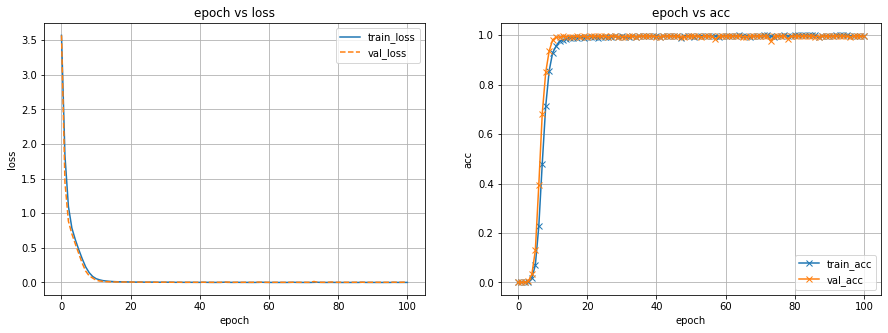

In [205]:
fig = plt.figure(figsize=(15,5))

# ====== Plot Loss ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Plot Metric ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_train_acc, marker='x', label='train_acc')
ax2.plot(list_epoch, list_val_acc, marker='x', label='val_acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs acc')


plt.show()


## Evaluate the trained model on the test set

In [206]:
from torch.distributions.categorical import Categorical

In [207]:
model = Seq2seq(preprocessor.human_num_tokens, preprocessor.human_num_tokens, args.emb_dim, args.emb_dim, args.hidden_dim, num_layers = args.num_layers, dropout = args.dropout, device = device)
model.load_state_dict(torch.load('./model/model_dict_best.pt'))

<All keys matched successfully>

In [213]:
test_human_sequences, test_machine_sequences = preprocessor.get_sequences_of_test_texts(cleaned_test)
test_dataset = DTDataset(test_human_sequences, test_machine_sequences)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = args.batch_size, shuffle = False, collate_fn = pad_collate)

model.to(device)

model.eval() # Set the model be 'evaluate mode' 
    
with torch.inference_mode():

    test_acc = 0 # to sum up each batch

    for batch_X, batch_y in test_dataloader:

        # ****** Transfer data to device ****** #
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        pred_y = model.infer(batch_X, batch_y.shape[1] - 1, SOS_token_idx)

        test_acc += torch.all((pred_y.argmax(dim = 2) == batch_y[:, 1:]), dim = 1).sum().item()

    test_acc = test_acc / num_test

print(f"Accuracy on the test set: {test_acc * 100: .2f}%")

Accuracy on the test set:  99.60%


## Try it out

In [209]:
def predict_sequence(input_seq, model, SOS_idx, max_seq_len):
    '''
            This function is used to generate an output sequence self-recursively according to 
        an input sequence.
    '''
    model.eval()
    model.to(device)
    
    input_seq_formatted = torch.tensor([input_seq], dtype = torch.int64).to(device)

    output_seq = model.infer(input_seq_formatted, max_seq_len, SOS_token_idx)
    
    return output_seq.argmax(dim = 2)[0]


Firstly, see how the model predicts the training data.

In [210]:
for i in range(5):

    input_seq = preprocessor.human_sequences[i]

    output_seq = predict_sequence(input_seq, model, 1, 10)
    
    output_seq = output_seq.cpu().detach().numpy().tolist()
    
    output_seq_formatted = []
    for ele in output_seq:
        if ele != 2:
            output_seq_formatted.append(ele)
        else:
            break

    print('\n')
    
    print(f"[{' '.join([preprocessor.human_idx2char[token] for token in preprocessor.human_sequences[i][1:-1]])}]")
    print(f"True: {''.join([preprocessor.machine_idx2char[token] for token in preprocessor.machine_sequences[i][1:-1]])}")
    print(f"Pred: {''.join([preprocessor.machine_idx2char[token] for token in output_seq_formatted])}")




[1 4 UNK 0 1 UNK 2 0 0 3]
True: 2003-01-14
Pred: 2003-01-14


[1 3 UNK f e b r u a r y UNK 2 0 1 7]
True: 2017-02-13
Pred: 2017-02-13


[1 4 UNK 0 6 UNK 1 9 8 4]
True: 1984-06-14
Pred: 1984-06-14


[1 9 9 2 UNK m a y UNK 2 3]
True: 1992-05-23
Pred: 1992-05-23


[1 9 9 9 UNK 2 2 UNK o c t o b e r]
True: 1999-10-22
Pred: 1999-10-22


Now make up some dates and try the model on it.

In [211]:
input_sentences = [
                   ["2014,05,06"], 
                   ["2022/12/21"], 
                   ["19 April 1993"],
                   ['May, 01, 2000'],
                   ['24,08,2018']
                  ]

input_cleaned = preprocessor.cleanse_corpus(input_sentences)

input_seqs = preprocessor.get_sequences_of_inference_texts(input_cleaned)

for i in range(len(input_seqs)):
    input_seq = input_seqs[i]
    
    output_seq = predict_sequence(input_seq, model, 1, 10)
    
    output_seq = output_seq.cpu().detach().numpy().tolist()
    
    output_seq_formatted = []
    for ele in output_seq:
        if ele != 2:
            output_seq_formatted.append(ele)
        else:
            break

    words = []
    for idx in output_seq_formatted:
        words.append(preprocessor.machine_idx2char[idx])
    output_sentence = "".join(words)

    print(f"H: {input_sentences[i][0]}")
    print(f"[{' '.join([preprocessor.human_idx2char[token] for token in input_seq[1:-1]])}]")
    print(f"M: {output_sentence}")
    print('\n')

H: 2014,05,06
[2 0 1 4 UNK 0 5 UNK 0 6]
M: 2014-05-06


H: 2022/12/21
[2 0 2 2 UNK 1 2 UNK 2 1]
M: 2022-12-21


H: 19 April 1993
[1 9 UNK a p r i l UNK 1 9 9 3]
M: 1993-04-19


H: May, 01, 2000
[m a y UNK 0 1 UNK 2 0 0 0]
M: 2000-05-01


H: 24,08,2018
[2 4 UNK 0 8 UNK 2 0 1 8]
M: 2018-08-24




Not bad eh?